# 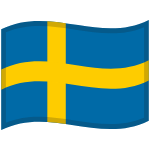 Welcome to the Sweden challenge 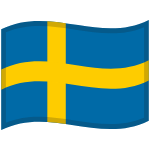

In this challenge we will try to save Swedens economy by analyzing and improving LUND's pricing model.  
To do that, let's start by taking a look at the dataset.

In [ ]:
!pip -q install "numpy==1.26.4" "tensorflow==2.17.0"

In [ ]:
import pandas as pd

df = pd.read_csv("data/clean_LUND_dataset.csv")
df.head()

### These are the features we have available in the dataset
**name** - (String) The name of the furniture.  
**category** - (String) What type of furniture it is. This will be converted to multiple columns with 1 or 0 if it's that category or not (to make it easy for the AI to read).  
**price** - (Float) The current price of the product.  
**old_price** - (Float) A previous price of the product, same as the current price in many cases.  
**sellable_online** - (Bool) If the item is sellable online, this will be True.  
**other_colors** - (Bool) If the item has other color variants, this will be True.  
**width** - (Float) The width of the item, if applicable.  
**depth** - (Float) The depth of the item, if applicable.  
**height** - (Float) The height of the item, if applicable.  
**discounted** - (Int) Takes 1 if the item is discounted, 0 otherwise.  
**width_d** - (Int) Takes 1 if it had a weight or 0 if it was NaN and was assigned a value through interpolation.  
**height_d** -  (Int) Takes 1 if it had a height or 0 if it was NaN and was assigned a value through interpolation.  
**depth_d** -  (Int) Takes 1 if it had a depth or 0 if it was NaN and was assigned a value through interpolation.  
**discount_amount** - (Float) How much to discount the item with.  
**size** - (Float) The total size of the item, 1 in case none of the shapes were given.  

We see a good mount of features (columns) in the dataset with varying values.  
The first thing we need to do is to select which of these features will be used to train our model.  

## Time to pick your features!
Choose the features you want to include in your training.  
We need to choose input features as well as an output feature (we can't use Category as output).  

Don't forget to set your model name to something interesting!

In [2]:
MODEL_NAME = "new_model"

# 👇 Edit these values
INPUT_FEATURES = [
    "category",
    "sellable_online",
    "other_colors",
    "width",
    "height",
    "depth",
    "width_d",
    "height_d",
    "depth_d",
    "discounted",
    "discount_amount",
    "size"
]
PREDICT_TARGET = "price"

The last thing we need to do is select how our training/testing data split is going to look like.

In [3]:
def split_function(df):
    from sklearn.model_selection import train_test_split
    return train_test_split(df.drop(PREDICT_TARGET, axis=1), df[PREDICT_TARGET], shuffle=True, test_size=0.3, random_state=42) # 👈 You can also try edting this

## Let's train our model!
Since this challenge is about looking at features and data, we don't worry about how exactly the model looks like, so we will just run a train_model function and be happy 🤷‍♀️

In [ ]:
from support_functions.model_training import train_model
test = train_model(df, INPUT_FEATURES, PREDICT_TARGET, split_function, MODEL_NAME)

Great!  
We now have a model and some artifacts. They are saved in the folder with the same name as you gave variable **MODEL_NAME** if you want to take a look.

# Evaluation

Now let's do the fun part and *Evaluate* the model.  
We will do a few evaluations. The first one will show us these interesting things:
- #### **The Mean Square Error** - this is how far away we are from the correct value on average.
  - This should be **below 100**.
- #### **The worst prediction** - this will tell us what our worst prediction was and how far away it was.
  - This should be **below 5000** (although if it prices the item high rather than low, the management won't complain).
- #### **A list of all prices below 0** - we probably want as few in this list as possible, as giving furniture away for less than free is rarely a substainable business model.
  - There should be **0 negatively priced items**.

### MSE

In [ ]:
from support_functions.evaluate_model import model_evaluation
worst_df, below_zero_df = model_evaluation(MODEL_NAME, PREDICT_TARGET)

### Worst prediction

In [ ]:
worst_df

### Negative prices

In [ ]:
print(f"Number of negative prices: {len(below_zero_df)}")
below_zero_df.head()

I think this video from our competitor IKEA describes well the result we just saw:

In [ ]:
from IPython.display import YouTubeVideo

YouTubeVideo('NlWCLw75XnE', width=800, height=300)

Now that we have some insight into that the model *does* go wrong, let's see if we can get an understanding of *what's* going wrong.  
For that, we will use TrustyAI's **Counterfactual** and **SHAP** 🧙‍♂️

# TrustyAI

With TrustyAI we can understand not only that something is wrong, but also *what* is wrong.

## Counterfactual Analysis
Counterfactual analysis will tell us what values we would have to input to get a different, desired, answer than the one we got.  
Here we will use it to see what we would have to change in one of our results for the value to be possitive. 

We also need to choose a **DATAPOINT** to analyze. We can start with datapoint number 655, but you can pick any from the above list of datapoints which return value < 0.

In [9]:
DATAPOINT=655

In [ ]:
from support_functions.counterfactual import counterfactual
explanation = counterfactual(MODEL_NAME, PREDICT_TARGET, DATAPOINT)

We can now see the results of our counterfacutal analysis!  
In the first table it will show us how much it needed to change a feature to get the value to become possitive.  
It's noteworthy that it tries to do the smallest change possible.

In [ ]:
explanation.as_dataframe()

Here is a small version of that big table (for those like me who don't want to scoure through it).  
This small version only shows the feature that needed a change to make the result possitive.

In [ ]:
df = explanation.as_dataframe()
df[df.difference != 0.0]

Finally, we can see the exact same thing - the original value(s) vs what they need to be to make our prediction possitive.  
But, this time it's visualized in a nice graph!

In [ ]:
if not df[df.difference != 0.0].empty:
    explanation.plot()
else:
    print(f"We did not manage to make '{PREDICT_TARGET}' larger than '0', or it was already above '0'")

## SHAP

SHAP (SHapley Additive exPlanations) values will tell us what input features likely had the biggest contribution to making the output what it is.  
This is great to see what caused our bad predictions to be bad, and what features we need to look over extra in our dataset.  

Note that we for SHAP, just like Counterfactuals, analyze a single datapoint that we find interesting. Feel free to replace this with a number from the above list.

In [ ]:
from support_functions.shap import shap
shap_explanations = shap(MODEL_NAME, PREDICT_TARGET, DATAPOINT)

Now we can look at the results!

First, we will get a table of values.  
Here we can see the **Mean Background Value** - this is the average base value we were talking about before.  
We can also see our **Value**, which is the normalized data point that we sent into the explainer. Red values are lower than the average value and green values are higher.  
Finally, we have the **SHAP Value**. These indicate how much that input feature had an effect on the output. Red indicates a negative contribution to the prediction while green a positive contribution. The larger the value, the larger the contribution.

You here see a lot more features than before, that's because we had to split the category feature into multiple ones.

In [ ]:
shap_explanations.as_html()[PREDICT_TARGET]

We can also visualize it as a candlestick plot, seeing how the different input features build up to the output value.  
The labels at the bottom are a bit hard to see, so best to check in the table above to see what feature it was. They follow the same order.  

In [ ]:
from support_functions.plot_shap import _matplotlib_plot
_matplotlib_plot(explanations=shap_explanations, output_name=PREDICT_TARGET)

## Now you try it!
See how small you can get the worst difference and the mean square error, and if you can remove all negative values.  
Start by removing features, changing the train and test split, or any other things you want to try your hands on.  
Good luck and have fun! 🙌